In [1]:
import os, sys
sys.path.append("third_party\LightSB")
sys.path.append("third_party\LightSB\ALAE")


from tqdm import tqdm
from matplotlib import pyplot as plt
from alae_ffhq_inference import load_model, encode, decode
import time

from sklearn.mixture import GaussianMixture
from GMMflow_main import *

## Configuration

In [2]:
# setup code taken from https://github.com/ngushchin/LightSB

INPUT_DATA = "MAN" # MAN, WOMAN, ADULT, CHILDREN
TARGET_DATA = "WOMAN" # MAN, WOMAN, ADULT, CHILDREN
DIM = 512
device = 'cuda'

epsilon = 0.1
N0 = 10
N1 =10

### TO DOWNLOAD PRE-PROCESSED ALAE DATA, UNCOMMENT THE CODE OF THE NEXT CELL.

In [3]:
# To download data use

# import gdown
# import os
# 
# urls = {
#     "third_party/LightSB/data/age.npy": "https://drive.google.com/uc?id=1Vi6NzxCsS23GBNq48E-97Z9UuIuNaxPJ",
#     "third_party/LightSB/data/gender.npy": "https://drive.google.com/uc?id=1SEdsmQGL3mOok1CPTBEfc_O1750fGRtf",
#     "third_party/LightSB/data/latents.npy": "https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8",
#     "third_party/LightSB/data/test_images.npy": "https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i",
# }
# 
# for name, url in urls.items():
#     gdown.download(url, os.path.join(f"{name}"), quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Vi6NzxCsS23GBNq48E-97Z9UuIuNaxPJ
To: D:\Documents\Georgia Tech\DCSL\GMMflow\third_party\LightSB\data\age.npy
100%|██████████| 560k/560k [00:00<00:00, 11.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SEdsmQGL3mOok1CPTBEfc_O1750fGRtf
To: D:\Documents\Georgia Tech\DCSL\GMMflow\third_party\LightSB\data\gender.npy
100%|██████████| 1.68M/1.68M [00:00<00:00, 84.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8
From (redirected): https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8&confirm=t&uuid=b6fbfed8-8590-4ed9-bfd9-3b5796f02909
To: D:\Documents\Georgia Tech\DCSL\GMMflow\third_party\LightSB\data\latents.npy
100%|██████████| 143M/143M [00:01<00:00, 106MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i
From (redirected): https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i&confirm=t&uuid=afdb1bbb

In [4]:
train_size = 60000
test_size = 10000

latents = np.load("third_party/LightSB/data/latents.npy")
gender = np.load("third_party/LightSB/data/gender.npy")
age = np.load("third_party/LightSB/data/age.npy")
test_inp_images = np.load("third_party/LightSB/data/test_images.npy")

train_latents, test_latents = latents[:train_size], latents[train_size:]
train_gender, test_gender = gender[:train_size], gender[train_size:]
train_age, test_age = age[:train_size], age[train_size:]

if INPUT_DATA == "MAN":
    x_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif INPUT_DATA == "WOMAN":
    x_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif INPUT_DATA == "ADULT":
    x_inds_train = np.arange(train_size)[
        (train_age >= 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        (test_age >= 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif INPUT_DATA == "CHILDREN":
    x_inds_train = np.arange(train_size)[
        (train_age < 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        (test_age < 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
x_data_train = train_latents[x_inds_train]
x_data_test = test_latents[x_inds_test]

if TARGET_DATA == "MAN":
    y_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif TARGET_DATA == "WOMAN":
    y_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif TARGET_DATA == "ADULT":
    y_inds_train = np.arange(train_size)[
        (train_age >= 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        (test_age >= 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif TARGET_DATA == "CHILDREN":
    y_inds_train = np.arange(train_size)[
        (train_age < 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        (test_age < 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
y_data_train = train_latents[y_inds_train]
y_data_test = test_latents[y_inds_test]

X_train = torch.tensor(x_data_train)
Y_train = torch.tensor(y_data_train)

X_test = torch.tensor(x_data_test)
Y_test = torch.tensor(y_data_test)

## Fit GMMs to the latents

In [5]:
start = time.time()

gmm0 = GaussianMixture(n_components=10, covariance_type='diag', random_state=0).fit(X_train)
gmm1 = GaussianMixture(n_components=10,  covariance_type='diag', random_state=0).fit(Y_train)
Mu0 = torch.tensor(gmm0.means_, dtype = torch.float32, device=device)
Sigma0 = torch.tensor(gmm0.covariances_, dtype = torch.float32, device=device)
Mu1 = torch.tensor(gmm1.means_, dtype = torch.float32, device=device)
Sigma1 = torch.tensor(gmm1.covariances_, dtype = torch.float32, device=device)

W0 = torch.tensor(gmm0.weights_, dtype = torch.float32, device=device)
W1 = torch.tensor(gmm1.weights_, dtype = torch.float32, device=device)

#define the sde
sde = GMMflow(Mu0, Mu1, Sigma0, Sigma1, W0, W1, epsilon=np.sqrt(epsilon), device = device)

end = time.time()
print("Training time: ", end-start)

Training time:  16.37573504447937


## Transform the samples

In [6]:
torch.cuda.empty_cache()
number_of_samples = 4 # number of samples for each image (for epsilon > 0)
y0 = X_test[0:10,:].to(device).unsqueeze(0).repeat(number_of_samples, 1, 1).reshape(-1, DIM)
t = torch.linspace(0, 1., 2, device=device)

with torch.no_grad():
    yf = []
    for y0_batch in tqdm(torch.split(y0, 1000, dim=0)):
        torch.cuda.empty_cache()
        y = torchsde.sdeint(sde, y0_batch, t, method='euler', dt=0.005) # y will be of size (t_size, batch_size, state_size)
        yf.append(y[-1, :, :].reshape(number_of_samples, -1, DIM))
        
# YF = torch.cat(yf, dim=1)[0]

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


In [7]:
# To download the required model run, run training_artifacts/download_all.py in the third_part/LightSB/ALAE folder.

model = load_model("third_party/LightSB/ALAE/configs/ffhq.yaml", training_artifacts_dir="third_party/LightSB/ALAE/training_artifacts/ffhq/")
model = model.to(device)
torch.cuda.empty_cache()
yf = y[-1, :, :].reshape(number_of_samples, -1, DIM)

In [8]:
decoded_all_GMM = []
with torch.no_grad():
    for k in range(number_of_samples):
        decoded_img = decode(model, yf[k, :].cuda())
        decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
        decoded_all_GMM.append(decoded_img)
        
decoded_all_GMM = np.stack(decoded_all_GMM, axis=1)

Text(0.67, 1.01, 'Go With the Flow')

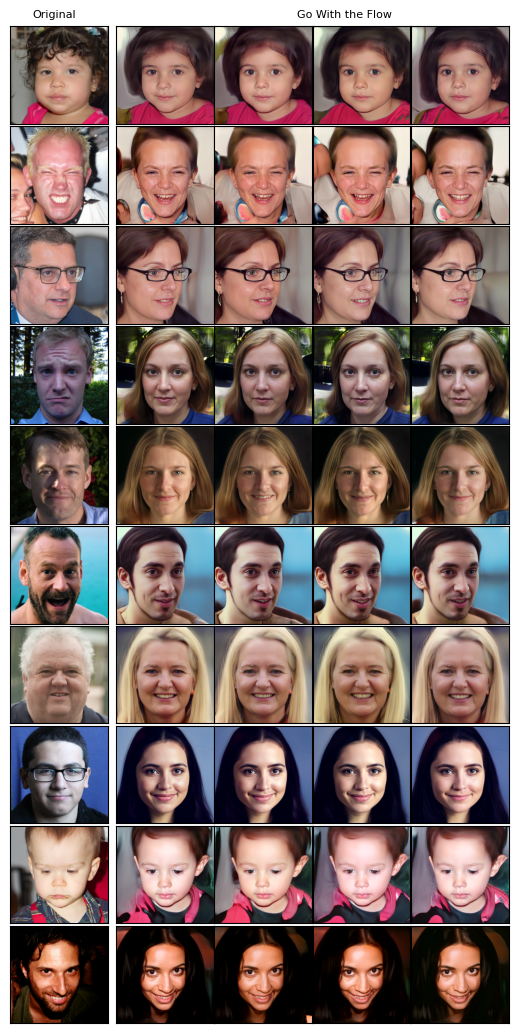

In [9]:
%matplotlib inline

inp_images = test_inp_images[x_inds_test[0:10]]

fig, axes = plt.subplots(nrows=10, 
                         ncols=number_of_samples + 2, 
                         figsize=(number_of_samples + 1, 10), 
                         dpi=100,
                         gridspec_kw={'width_ratios': [0.7, 0.05, 0.7, 0.7, 0.7, 0.7]} )

for i, ind in enumerate(range(10)):
    ax = axes[i]
    ax[0].imshow(inp_images[ind])
    ax[1].axis('off')

    for k in range(4):
  
        ax[k + 2].imshow(decoded_all_GMM[ind, k])
        ax[k + 2].get_xaxis().set_visible(False)
        ax[k + 2].set_yticks([])

    ax[0].get_xaxis().set_visible(False)
    ax[0].set_yticks([])

fig.tight_layout(pad=0.05)
plt.figtext(0.09, 1.01, 'Original', va="center", ha="center", size=8)
plt.figtext(0.67, 1.01, 'Go With the Flow', va="center", ha="center", size=8)